In [1]:
import sys
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines
import scipy.stats as stats
import pandas as pd

sys.path.append("..")
from util.simprop import prop
from util.plot import axtext, add_panel_letters

%matplotlib inline

In [2]:
FUNCTIONS = {
    'A':  [-5.117447424199997,  -5.117447424199997,  1.9464059407999987, 1.9464059407999987],
    'B':  [-8., 2., 4., 13.],
    'C':  [-10., 2., 5.5, 33.],
    'D':  [-12.699722249999999, 15.479622175000001,  5.527035135,       75.21215649999999]
}

FUNS = ['A', 'C', 'D']
FUNNAMES = ["Uncoupled", "Weak coupling", "Strong coupling"]

In [3]:
conns = [np.genfromtxt(fn) for fn in [f"../data/conn/vep/id{i:03d}.txt" for i in range(1, 51)]]
nreg = conns[0].shape[0]

## Functions

In [10]:
def f(c, y, q):
    q11, q12, qa21, qa22 = q
    q21 = q11 + qa21
    q22 = q12 + qa22
    
    c1, c2 = -1, 1
    y1, y2 = 0, 1
    blint = 1./((c2 - c1)*(y2 - y1)) * (  q11*(c2 - c)*(y2 - y) + q21*(c - c1)*(y2 - y)
                                        + q12*(c2 - c)*(y - y1) + q22*(c - c1)*(y - y1))
    return np.exp(blint)    
    
def plot_hyperparams(q, ax=None):
    cs = np.linspace(-3.5, 3.5, 1000)
    ys = np.linspace(0, 1, 1000)
    css, yss = np.meshgrid(cs, ys)

    fcy = f(css, yss, q)
    logfcy = np.log(fcy)
    
    if ax is None:
        ax = plt.figure(figsize=(8, 3))
    else:
        plt.sca(ax)
    
    plt.imshow(logfcy,  extent=[cs[0], cs[-1], ys[0], ys[-1]], origin='lower', aspect='auto', vmin=-10, vmax=0)
    plt.colorbar()
    plt.plot(cs, 0.8*stats.norm().pdf(cs), 'r-', lw=2)
    # plt.scatter([c1, c1, c2, c2], [y1, y2, y1, y2], marker='x', color='k', s=50, clip_on=False, lw=1)
    
    plt.xlim(-3.5, 3.5)
    plt.xticks([-3, -2, -1, 0, 1, 2, 3])
    plt.xlabel("Excitability $c$", fontsize=12)
    
    plt.ylim(0., 1.)
    plt.yticks([0, 0.5, 1.])
    plt.ylabel("Network input $y$", fontsize=12)

In [5]:
def generate_dataset(nsamples, names, qs, plot=False):
    T_LIM = 90.0
    rows = []

    for name, q in zip(names, qs):
        for i in range(nsamples):
            conn = conns[np.random.choice(len(conns))]
            c = np.random.normal(0, 1, size=nreg)
            t = prop(c, conn, q)

            szmask = t < T_LIM

            if sum(szmask) == 0:
                continue

            if plot:
                plt.subplot(nrows, ncols, i+1)
                plt.hist(t[szmask])

            rows.append(OrderedDict(
                fun=name,
                sim=i,
                fracsz=np.mean(szmask),
                tstd=np.std(t[szmask]),        
                td10=np.percentile(t[szmask], 10),
                td50=np.percentile(t[szmask], 50),
                td90=np.percentile(t[szmask], 90),
            ))

    df = pd.DataFrame(rows)
    
    return df

In [6]:
df = generate_dataset(10000, FUNS, [FUNCTIONS[f] for f in FUNS])

## Plot

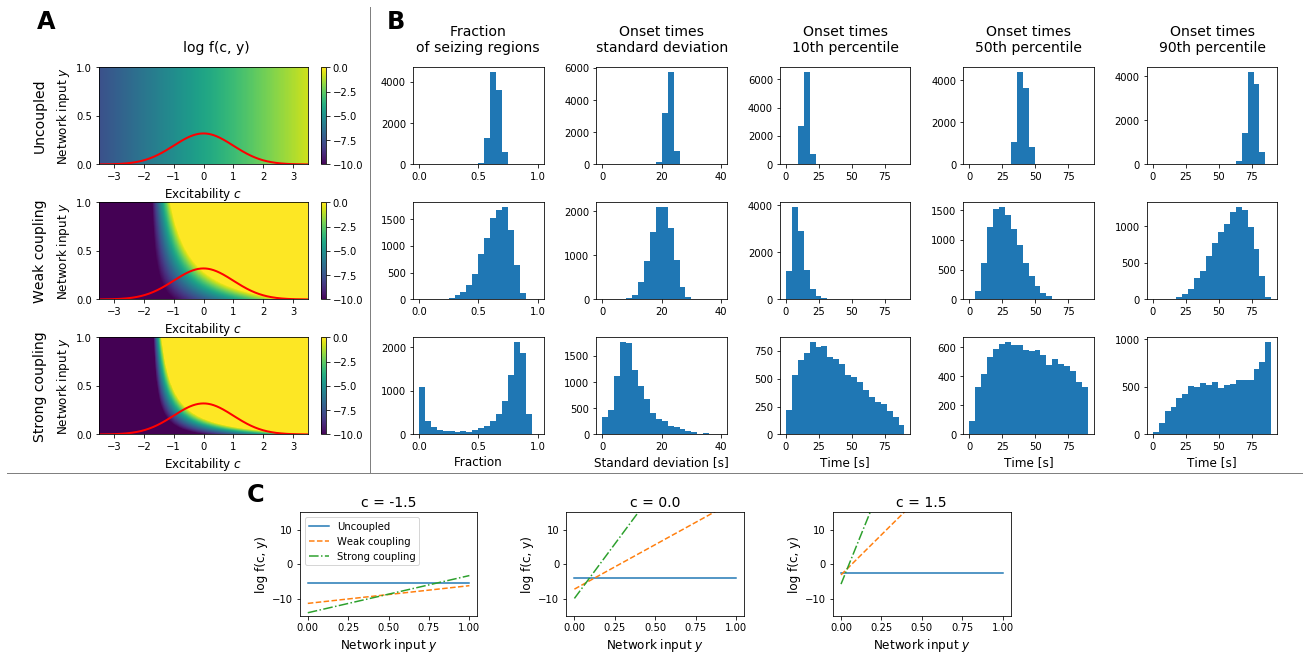

In [12]:
fig = plt.figure(figsize=(18, 9))

gs = gridspec.GridSpec(2, 1, hspace=0.3, left=0.02, right=0.98, bottom=0.06, top=0.98, height_ratios=[4, 1])
gs1 = gridspec.GridSpecFromSubplotSpec(4, 7, gs[0], height_ratios=[0.1, 1, 1, 1], width_ratios=[0.1, 2, 1, 1, 1, 1, 1],
                                       wspace=0.4, hspace=0.5)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, gs[1], wspace=0.5)

# Labels
axtext(plt.subplot(gs1[0, 1]), "\nlog f(c, y)      ", va='top')
axtext(plt.subplot(gs1[0, 2]), "Fraction\nof seizing regions", va='top')
axtext(plt.subplot(gs1[0, 3]), "Onset times\nstandard deviation", va='top')
axtext(plt.subplot(gs1[0, 4]), "Onset times\n10th percentile", va='top')
axtext(plt.subplot(gs1[0, 5]), "Onset times\n50th percentile", va='top')
axtext(plt.subplot(gs1[0, 6]), "Onset times\n90th percentile", va='top')

axes = []

# Functions
# for i, (name, q, df) in enumerate([('Uncoupled', qA, dfA), ('Weak', qB, dfB), ('Mid', qB2, dfB2), ('Strong', qC, dfC)]):
for i, (fun, funname) in enumerate(zip(FUNS, FUNNAMES)):
    axtext(plt.subplot(gs1[i+1, 0]), funname, rotation='vertical')   
    
    ax = plt.subplot(gs1[i+1, 1])
    plot_hyperparams(FUNCTIONS[fun], ax)
    if i == 0:
        axes.append(ax)

    dff = df[df.fun == fun]
    
    ax = plt.subplot(gs1[i+1, 2])
    plt.hist(dff.fracsz, bins=np.linspace(0, 1, 21))
    if i == 2:
        plt.xlabel("Fraction", fontsize=12)
    if i == 0:
        axes.append(ax)

    ax = plt.subplot(gs1[i+1, 3])
    plt.hist(dff.tstd, bins=np.linspace(0, 40, 21))
    if i == 2:
        plt.xlabel("Standard deviation [s]", fontsize=12)

    ax = plt.subplot(gs1[i+1, 4])    
    plt.hist(dff.td10, bins=np.linspace(0, 90, 21))
    if i == 2:
        plt.xlabel("Time [s]", fontsize=12)

    ax = plt.subplot(gs1[i+1, 5])
    plt.hist(dff.td50, bins=np.linspace(0, 90, 21))
    if i == 2:
        plt.xlabel("Time [s]", fontsize=12)

    ax = plt.subplot(gs1[i+1, 6])
    plt.hist(dff.td90, bins=np.linspace(0, 90, 21))
    if i == 2:
        plt.xlabel("Time [s]", fontsize=12)


# Profile
linestyles = ['-', '--', '-.']
for i, c in enumerate([-1.5, 0, 1.5]):
    ax = plt.subplot(gs2[i+1])
    y = np.linspace(0, 1, 100)
    plt.title(f"c = {c:.1f}", fontsize=14)
    for j, (fun, funname) in enumerate(zip(FUNS, FUNNAMES)):
        q = FUNCTIONS[fun]
        
        fcy = f(c, y, q)
        plt.plot(y, np.log(fcy), label=funname, ls=linestyles[j])
    
    plt.ylim(-15, 15)
    plt.xlabel("Network input $y$", fontsize=12)
    plt.yticks([-10, 0, 10])
    plt.ylabel("log f(c, y)", fontsize=12)
    
    if i == 0:
        plt.legend(loc='upper left')
        axes.append(ax)
        
# Labeling etc
add_panel_letters(fig, axes, xpos=[-0.3, -0.2, -0.3], ypos=[1.4, 1.4, 1.1], fontsize=24)
axbg = plt.axes([0,0,1,1], facecolor=None)
plt.axis('off')
axbg.add_line(lines.Line2D([0., 1.], [0.28, 0.28], color='0.5', lw=1))
axbg.add_line(lines.Line2D([0.28, 0.28], [0.28, 1], color='0.5', lw=1))

plt.savefig("./img/functions.pdf")